<a href="https://colab.research.google.com/github/yimeiwen/molecularsolubility/blob/main/Molecular_Solubility_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-11-02 20:36:31--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’

Miniconda3-py37_4.8 100%[===================>]  81.12M   202MB/s    in 0.4s    

2022-11-02 20:36:32 (202 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | / - \ | / - \ | / - \ | failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | / - \ | / - 

In [ ]:
import pandas as pd
solu=pd.read_csv('solubility.txt')

In [ ]:
solu

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [ ]:
#Simplified Molecular-Input Line Entry System
#need to convert Smiles string into a rdkit object
from rdkit import Chem
Chem.MolFromSmiles(solu.SMILES[0])


In [ ]:
num1=Chem.MolFromSmiles('C1CC(C1)(C1)C1')
num1.GetNumAtoms()

6

Calculate molecular descriptors in rdkit

convert list of molecules to rdkit object

method 1

In [ ]:
mol_list=[]
for element in solu.SMILES:
  mol=Chem.MolFromSmiles(element)
  mol_list.append(mol)

In [ ]:
len(mol_list)

1144

method 2

In [ ]:
mol_list2=[Chem.MolFromSmiles(element) for element in solu.SMILES]

In [ ]:
len(mol_list2)

1144

In [ ]:
mol_list[:5]

***3. Calculate molecular descriptors***

To predict LogS, 4 features were used, first three can be computed by rdkit, #4 need manual calculate


1.   cLogP(Octanol-water partition coefficient)
2.   MolecularWeight
1.   Number of Rotatable Bonds

2.   Aromatic proportion=(nums of Aromatic atoms)/(total nums of heavy atoms)








LogP, MW and Rotatable Bond

In [ ]:
import numpy as np
from rdkit.Chem import Descriptors,Crippen

In [ ]:
def generate(smiles,verbose=False):
  moldata=[]
  for elem in smiles:
    mol=Chem.MolFromSmiles(elem)
    moldata.append(mol)

  baseData=np.arange(1,1)
  i=0
  for mol in moldata:
    desc_MolLogP=Descriptors.MolLogP(mol)
    desc_Lop=Crippen.MolLogP(mol)
    desc_MolWt=Descriptors.MolWt(mol)
    desc_NumRotatableBonds=Descriptors.NumRotatableBonds(mol)

    row=np.array([desc_MolLogP,desc_MolWt,desc_NumRotatableBonds])

    if(i==0):
      baseData=row
    else:
      baseData=np.vstack([baseData,row])
    i=i+1

  columnNames=['MolLogP','MolWt','NumRotatableBonds']
  descriptors=pd.DataFrame(data=baseData,columns=columnNames)
  return descriptors

In [ ]:
df=generate(solu.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


Compute a single molecule

number of aromatic atoms

In [ ]:
m=Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')

In [ ]:
aromatic_atoms=[m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aromatic_atoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [ ]:
def AromaticAtoms(m):
  aromatic_atoms=[m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count=[]
  for i in aromatic_atoms:
    if i==True:
        aa_count.append(1)
  sum_aa_count=sum(aa_count)
  return sum_aa_count


In [ ]:
AromaticAtoms(m)

19

Computing for mlecules in the entire dataset

In [ ]:
desc_AromaticAtoms=[AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

In [ ]:
desc_HeavyAtomCount=[Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

In [ ]:
m=Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AromaticAtoms(m)/Descriptors.HeavyAtomCount(m)

0.5588235294117647

In [ ]:
desc_AromaticProportion=[AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [ ]:
df_desc_AromaticProportion=pd.DataFrame(desc_AromaticProportion,columns=['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


X matrix（Combining all computed descriptors into one dataframe

In [ ]:
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


In [ ]:
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


In [ ]:
#combine two dataframe to produce X matrix, so 4 features will be together
X=pd.concat([df,df_desc_AromaticProportion],axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


Y matrix

In [ ]:
Y=solu.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

Data Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

Linear Regression Model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
model=linear_model.LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

In [ ]:
Y_predict_train=model.predict(X_train)

In [ ]:
print('Coefficients: ', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(Y_train, Y_predict_train))
print('Coefficient of determination (R^2)): %.2f' % r2_score(Y_train, Y_predict_train))

Coefficients:  [-0.73250504 -0.00641517 -0.01985736 -0.43987947]
Intercept: 0.24744740144979582
Mean squared error (MSE): 0.99
Coefficient of determination (R^2)): 0.77


In [ ]:
Y_predict_test=model.predict(X_test)
print('Coefficients: ', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(Y_test, Y_predict_test))
print('Coefficient of determination (R^2)): %.2f' % r2_score(Y_test, Y_predict_test))

Coefficients:  [-0.73250504 -0.00641517 -0.01985736 -0.43987947]
Intercept: 0.24744740144979582
Mean squared error (MSE): 1.10
Coefficient of determination (R^2)): 0.75


In [ ]:
print('LogS = %.2f %.2f LogP %.4f MW %.4f RB %.2f AP' % (model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3] ) )

LogS = 0.25 -0.73 LogP -0.0064 MW -0.0199 RB -0.44 AP


In [ ]:
yintercept = '%.2f' % model.intercept_
LogP = '%.2f LogP' % model.coef_[0]
MW = '%.4f MW' % model.coef_[1]
RB = '%.4f RB' % model.coef_[2]
AP = '%.2f AP' % model.coef_[3]

In [ ]:
print('LogS = ' + 
      ' ' + 
      yintercept + 
      ' ' + 
      LogP + 
      ' ' + 
      MW + 
      ' ' + 
      RB + 
      ' ' + 
      AP)

LogS =  0.25 -0.73 LogP -0.0064 MW -0.0199 RB -0.44 AP


Quick check of variable dimensions of Train and Test sets

In [ ]:
Y_train.shape, Y_predict_train.shape

((915,), (915,))

In [ ]:
Y_test.shape,Y_predict_test.shape

((229,), (229,))

Vertical Plot

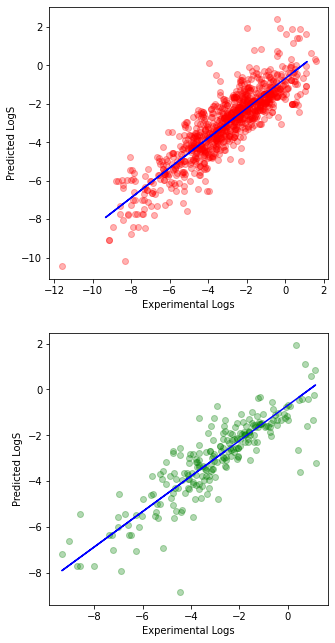

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,11))
#2 row, 1 colum, plt 1
plt.subplot(2,1,1)
plt.scatter(x=Y_train, y=Y_predict_train, c='red', alpha=0.3) #alpha transparency of color

z=np.polyfit(Y_train,Y_predict_train,1)
p=np.poly1d(z)
plt.plot(Y_test,p(Y_test),'blue')
plt.ylabel('Predicted LogS')
plt.xlabel('Experimental Logs')
#2 row, 2 column, plot 2

plt.subplot(2,1,2)
plt.scatter(x=Y_test,y=Y_predict_test, c='green',alpha=0.3)

z=np.polyfit(Y_test, Y_predict_test,1)
np.poly1d(z)
plt.plot(Y_test,p(Y_test),'blue')

plt.xlabel('Experimental Logs')
plt.ylabel('Predicted LogS')
plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')

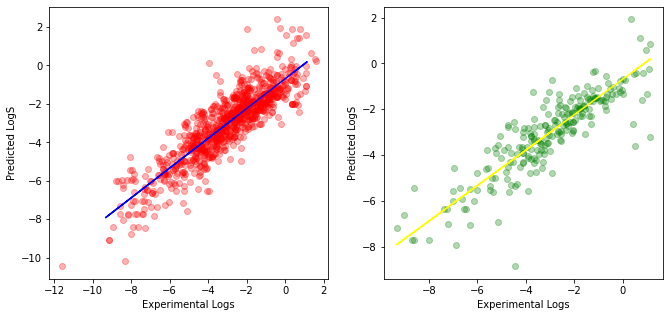

In [ ]:
plt.figure(figsize=(11,5))  #width is 5, length is 5
#1 row, 2 colum, plt 1
plt.subplot(1,2,1)
plt.scatter(x=Y_train, y=Y_predict_train, c='red', alpha=0.3)

z=np.polyfit(Y_train,Y_predict_train,1)
p=np.poly1d(z)
plt.plot(Y_test,p(Y_test),'blue')
plt.ylabel('Predicted LogS')
plt.xlabel('Experimental Logs')
#2 row, 2 column, plot 2
plt.subplot(1,2,2)
plt.scatter(x=Y_test,y=Y_predict_test, c='green',alpha=0.3)

z=np.polyfit(Y_test, Y_predict_test,1)
np.poly1d(z)
plt.plot(Y_test,p(Y_test),'yellow')

plt.xlabel('Experimental Logs')
plt.ylabel('Predicted LogS')
plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')

Save to CSV file with 4 features

In [ ]:
dataset=pd.concat([X,Y],axis=1)
dataset.to_csv('solubility_with_descriptors.csv')
dataset.head()

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,measured log(solubility:mol/L)
0,2.5954,167.850,0.0,0.0,-2.18
1,2.3765,133.405,0.0,0.0,-2.00
2,2.5938,167.850,1.0,0.0,-1.74
3,2.0289,133.405,1.0,0.0,-1.48
4,2.9189,187.375,1.0,0.0,-3.04


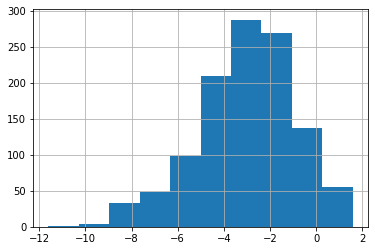

In [ ]:
Y.hist()

In [ ]:
Y_predict=model.predict(X)
Y_predict

array([-2.73048191, -2.34916614, -2.74916725, ..., -4.76004291,
       -4.19460481, -2.60601249])

In [ ]:
Y_pred=pd.DataFrame(Y_predict,columns=['Y_predict'])
Y_pred

,Y_predict
0,-2.730482
1,-2.349166
2,-2.749167
3,-2.114405
4,-3.112561
...,...
1139,-3.211131
1140,-4.280482
1141,-4.760043
1142,-4.194605


In [ ]:
df=pd.concat([dataset,Y_pred],axis=1)
df

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,measured log(solubility:mol/L),Y_predict
0,2.59540,167.850,0.0,0.000000,-2.180,-2.730482
1,2.37650,133.405,0.0,0.000000,-2.000,-2.349166
2,2.59380,167.850,1.0,0.000000,-1.740,-2.749167
3,2.02890,133.405,1.0,0.000000,-1.480,-2.114405
4,2.91890,187.375,1.0,0.000000,-3.040,-3.112561
...,...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144,-3.211131
1140,3.42130,286.114,2.0,0.333333,-4.925,-4.280482
1141,3.60960,308.333,4.0,0.695652,-3.893,-4.760043
1142,2.56214,354.815,3.0,0.521739,-3.790,-4.194605


PyCaret for machine learning

In [ ]:
!pip install pycaret[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
     |████████████████████████████████| 15.3 MB 9.3 MB/s 
ERROR: yellowbrick 1.5 has requirement scikit-learn>=1.0.0, but you'll have scikit-learn 0.23.2 which is incompatible.
ERROR: tensorboardx 2.5.1 has requirement protobuf<=3.20.1,>=3.8.0, but you'll have protobuf 4.21.9 which is incompatible.
ERROR: ray 2.0.1 has requirement click<=8.0.4,>=7.0, but you'll have click 8.1.3 which is incompatible.
ERROR: ray 2.0.1 has requirement protobuf<4.0.0,>=3.15.3, but you'll have protobuf 4.21.9 which is incompatible.
ERROR: optuna 3.0.3 has requirement importlib-metadata<5.0.0, but you'll have importlib-metadata 5.0.0 which is incompatible.
ERROR: optuna 3.0.3 has requirement scipy<1.9.0,>=1.7.0, but you'll have scipy 1.5.4 which is incompatible.
ERROR: mlxtend 0.21.0 has requirement scikit-learn>=1.0.2, but you'll hav

In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Werkzeug-2.2.2-py3-none-any.whl (232 kB)
ERROR: explainerdashboard 0.3.8.2 has requirement Werkzeug<=2.0.3, but you'll have werkzeug 2.2.2 which is incompatible.
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.0.3
    Uninstalling Werkzeug-2.0.3:
      Successfully uninstalled Werkzeug-2.0.3


In [ ]:
!pip install --pre pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycaret.regression import *

In [ ]:
import pandas as pd
df=pd.read_csv('solubility_with_descriptors.csv')
df.head()

,Unnamed: 0,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,measured log(solubility:mol/L)
0,0,2.5954,167.850,0.0,0.0,-2.18
1,1,2.3765,133.405,0.0,0.0,-2.00
2,2,2.5938,167.850,1.0,0.0,-1.74
3,3,2.0289,133.405,1.0,0.0,-1.48
4,4,2.9189,187.375,1.0,0.0,-3.04


In [ ]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
ERROR: pycaret 2.3.10 has requirement scikit-learn==0.23.2, but you'll have scikit-learn 1.0.2 which is incompatible.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


In [ ]:
!pip install scikit-learn==0.23.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model=setup(data=df,target='logS',train_size=0.8, silent=True)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logS, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.8, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, norm

RuntimeError: ignored